In [4]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
import os
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
def get_each_point_error(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.append(error_list)
    return error_series_concatenated


def get_error_series(path, test_date):
    df = pd.read_csv(path, sep=";")
    error_series_str = df.loc[df['test_range'] == test_date, 'error_series'].values[0]
    error_list_rf = ast.literal_eval(error_series_str)
    return error_list_rf

In [6]:
# estado = "SP"
# transformations = ['normal', 'deseasonal', 'log']
# models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
# noResid = True
# val_date = '2022-03_2023-02'
# test_date = '2023-03_2024-02'

# dirs = [
#     '../datasets/venda/mensal/uf/gasolinac/',
#     # '../datasets/venda/mensal/uf/etanolhidratado/',
#     # '../datasets/venda/mensal/uf/glp/',
#     # '../datasets/venda/mensal/uf/oleodiesel/',
#     # '../datasets/venda/mensal/uf/querosenedeaviacao/',
# ]

# for directory in dirs:
#     for file in os.listdir(directory):
#         if file.endswith('.csv'):
#             uf = file.split("_")[1].upper()
#             derivado = file.split("_")[2].split(".")[0]
#             full_path = os.path.join(directory, file)
#             series = read_series(full_path)

#             # X = np.hstack()
#             stacks = []
            
#             for model in models:
#                 for transform in transformations:
#                     error_serie = get_each_point_error(
#                         f'./results_hybrid/{model}/{derivado}/{transform}/transform_{uf}.csv', 
#                         val_date
#                     )
#                     stacks.extend(error_serie)
#                     if noResid:
#                         try:
#                             error_serie = get_each_point_error(
#                                 f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', 
#                                 val_date
#                             )
#                             stacks.extend(error_serie)
#                         except:
#                             print(uf)
#                             print(model)
#                             print(derivado)
#                             print(transform)
#                             raise ValueError('error')
#             print(uf)
#             print(stacks)

def get_all_error_series(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.extend(error_list)
    
    return error_series_concatenated

In [7]:
estado = "SP"
transformations = ['normal', 'deseasonal', 'log']
models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
noResid = True
val_date = '2022-03_2023-02'
test_date = '2023-03_2024-02'

dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    # '../datasets/venda/mensal/uf/etanolhidratado/',
    # '../datasets/venda/mensal/uf/glp/',
    # '../datasets/venda/mensal/uf/oleodiesel/',
    # '../datasets/venda/mensal/uf/querosenedeaviacao/',
]


uf = estado
derivado = "etanolhidratado"
horizon = 12
# X = np.hstack()
stacks = []
transformations = ['normal', 'deseasonal', 'log']
rotulos_transformations = transformations.copy() 
rotulos_transformations.append("noresid")  


model_target = 'svr'
transform_target = 'deseasonal'
preds_start = []

erros = pd.DataFrame()
for model in models:
    for transform in transformations:
        error_serie = get_all_error_series(
            f'./results_hybrid/{model}/{derivado}/{transform}/transform_{uf}.csv', 
            val_date
        )

        #condicao para retirar o ponto de partida (X_test) do train
        if model == model_target and transform == transform_target:
            preds_start = error_serie[-12:]
            error_serie = error_serie[:-12]
        
        data = rolling_window(error_serie, 12)
        
        # data[rotulos_transformations] = 0
        # data[models] = 0

        # data[model] = 1
        # data[transform] = 1
        erros = pd.concat([data, erros], axis=0)
       
        if noResid:
            try:
                error_serie = get_all_error_series(
                    f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', 
                    val_date
                )
                data = rolling_window(error_serie, 12)
                # data[rotulos_transformations] = 0
                # data[models] = 0

                # data[model] = 1
                # data[transform] = 1
                erros = pd.concat([data, erros], axis=0)
                
            except:
                print(uf)
                print(model)
                print(derivado)
                print(transform)
                raise ValueError('error')
            

erros = erros.reset_index(drop=True)
erros.columns = erros.columns.astype(str)
X_train = erros.drop(columns=['12'])
y_train = erros[['12']].squeeze()

start_norm = znorm(preds_start)
X_test = np.array([start_norm])
start_norm

array([ 2.31759881,  1.01935714, -0.11973558,  0.01795488,  0.44260007,
        0.17255629,  0.67883331, -0.59314517, -0.97452236, -0.49448217,
       -1.6204139 , -0.84660132])

In [8]:
def preds_recursive_meta(example, model, horizon):
  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    example = example[:,1:]

    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# rg = RandomForestRegressor()
# rg.fit(X_train, y_train)
# predictions = preds_recursive_meta(X_test, rg, horizon)
# preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))
# real = [9043.149614886148, -3091.197742374963, 130880.96228778805, 79688.56315034768, 28905.223024249193, 25031.35794872581, 10243.253485904075, -38512.782241672976, -60414.857104607625, -61809.82647351979, -87323.63127602031, -141079.0506399559]
# plt.plot(preds_real, label='Predictions')  # Adiciona a legenda "Predictions"
# plt.plot(real, label='Real')  

# # Adicionando título e rótulos aos eixosvalores
# plt.title('Gráfico de Valores')
# plt.xlabel('Índice')
# plt.ylabel('Valores')
# plt.legend()
# # Exibindo o gráfico
# plt.show()

In [10]:
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
print(derivado)
print(estado)
print(transform_target)
treino, teste = train_test_stats(series, 12)
transformer = STLTransformer(sp=12) 
stl = transformer.fit(treino)
# train_stl = stl.seasonal_ + stl.trend_
train_stl = treino
train_tf = transform_regressors(train_stl, format=transform_target)

etanolhidratado
SP
deseasonal


In [11]:
def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results

preds_arima = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', "2023-03_2024-02", teste.index)
# somados = preds_arima - preds_real.values
preds_arima

timestamp
2023-03    658619.970348
2023-04    650126.143545
2023-05    661985.382053
2023-06    655220.687027
2023-07    670657.881209
2023-08    685261.455057
2023-09    682175.202706
2023-10    703800.398029
2023-11    669985.657208
2023-12    717848.941783
2024-01    648979.461550
2024-02    636907.550232
Freq: M, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

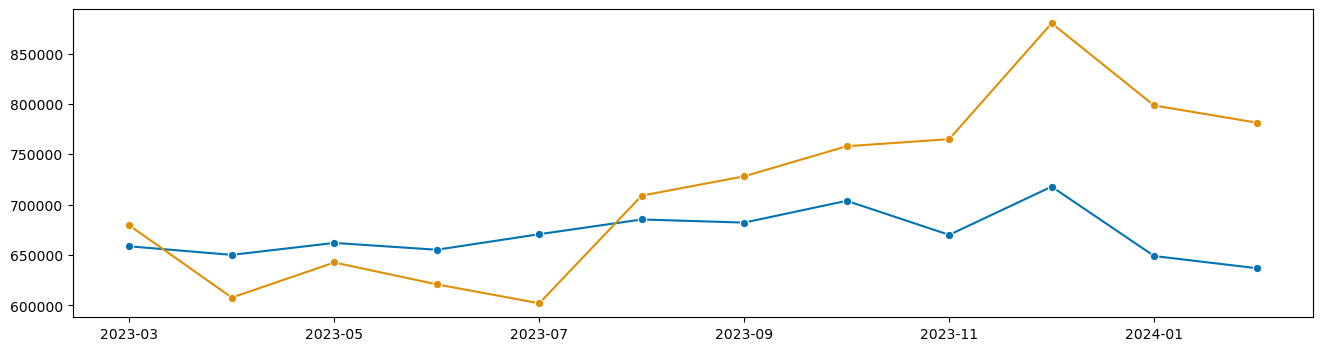

In [13]:


data = rolling_window(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=teste.index)]), 12)
data = data.dropna()
X_train, X_test, y_train, _ = train_test_split(data, horizon)

rg = SVR(**{'kernel': 'rbf', 'C': 10, 'gamma': 3, 'epsilon': 0.5})
rg.fit(X_train, y_train)
predictions = recursive_multistep_forecasting(X_test, rg, horizon)
preds = pd.Series(predictions, index=teste.index)
preds_real = reverse_regressors(train_stl, preds, format=transform_target)
plot_series(preds_real, teste)